In [1]:
import numpy as np
from scipy.stats import ttest_1samp 
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import * 


# Project overview

## Differential Privacy
This project demonstrates how Differential Privacy (DP) can be applied to a data and how an attacker could still infer individual information. This example revolves around anonymizing a dataset of individual heights that contains a significant outlier. In this small example we use a person's height which differs unbelievely from others, however in real-world example, an individulas can have a specific sign that stands out from others. 

## The goal

We want to:

- Protect people's data using a method called Differential Privacy.
- Show how an attacker could still infer private information, especially when someone stands out (like the outlier).

data shape: (5, 1)


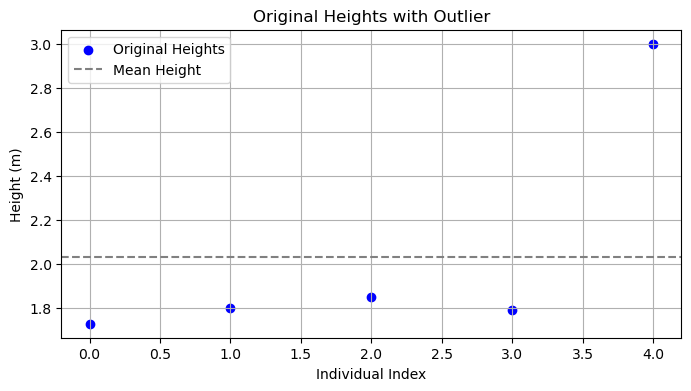

In [2]:
test_data = np.array([1.73, 1.8, 1.85, 1.79, 3.0])
test_data = test_data.reshape(-1, 1)
print(f"data shape: {test_data.shape}")
plt.figure(figsize=(8, 4))
plt.scatter(range(len(test_data)), test_data, color='blue', label='Original Heights')
plt.axhline(np.mean(test_data), color='gray', linestyle='--', label='Mean Height')
plt.title("Original Heights with Outlier")
plt.xlabel("Individual Index")
plt.ylabel("Height (m)")
plt.legend()
plt.grid(True)
plt.show()

## Leave-One-Out (LOO) Estimation

The LOO method computes the mean of the dataset each time one participant is removed. This reveals how much influence each individual has on the mean, particularly sensitive in datasets with outliers.

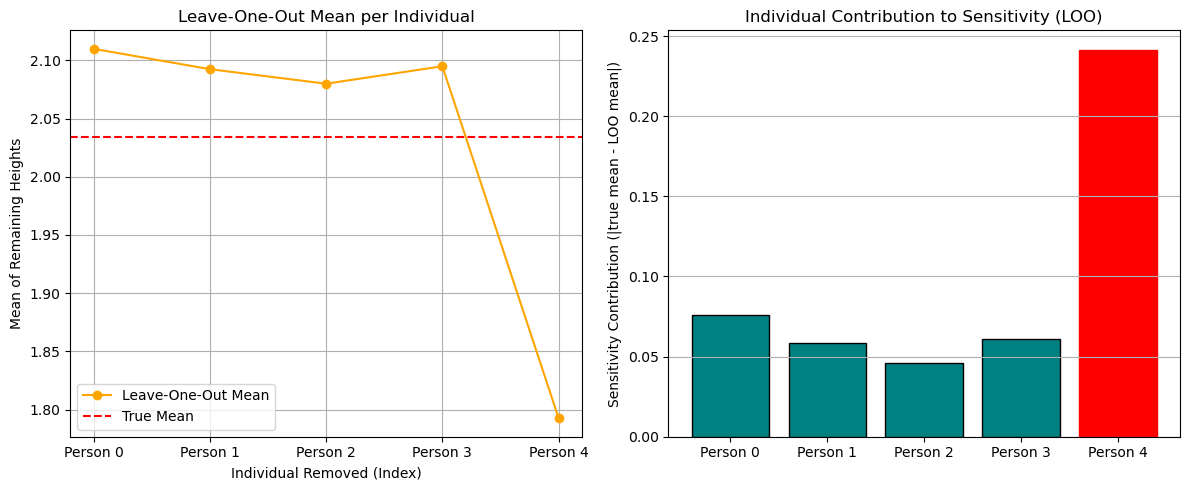

In [3]:
aprx_est = np.array([np.mean(np.delete(test_data, i)) for i in range(test_data.shape[0])]).reshape(-1, 1)

n = len(test_data)
true_mean = np.mean(test_data)
loo_means = np.array([np.mean(np.delete(test_data, i)) for i in range(n)])
sensitivity_contributions = np.abs(true_mean - loo_means)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(len(aprx_est)), aprx_est, marker='o', color='orange', label='Leave-One-Out Mean')
axes[0].axhline(true_mean, color='red', linestyle='--', label='True Mean')
axes[0].set_title("Leave-One-Out Mean per Individual")
axes[0].set_xlabel("Individual Removed (Index)")
axes[0].set_xticks(range(n))
axes[0].set_xticklabels([f"Person {i}" for i in range(n)])
axes[0].set_ylabel("Mean of Remaining Heights")
axes[0].legend()
axes[0].grid(True)

bars = axes[1].bar(range(n), sensitivity_contributions, color='teal', edgecolor='black')
bars[-1].set_color('red')  
axes[1].set_xticks(range(n))
axes[1].set_xticklabels([f"Person {i}" for i in range(n)])
axes[1].set_ylabel("Sensitivity Contribution (|true mean - LOO mean|)")
axes[1].set_title("Individual Contribution to Sensitivity (LOO)")
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


## Observation:

One individual (with height 3.0 meters) causes a significant drop in the mean when removed, clearly indicating it's an outlier or someone that differs from others in height. An attacker could identify this participant due to their disproportionate influence on the aggregate statistic.

## Applying Differential Privacy

We implement a basic DP mechanism by adding Laplace noise scaled by sensitivity, defined here as the maximum deviation between the true mean and the leave-one-out estimates.

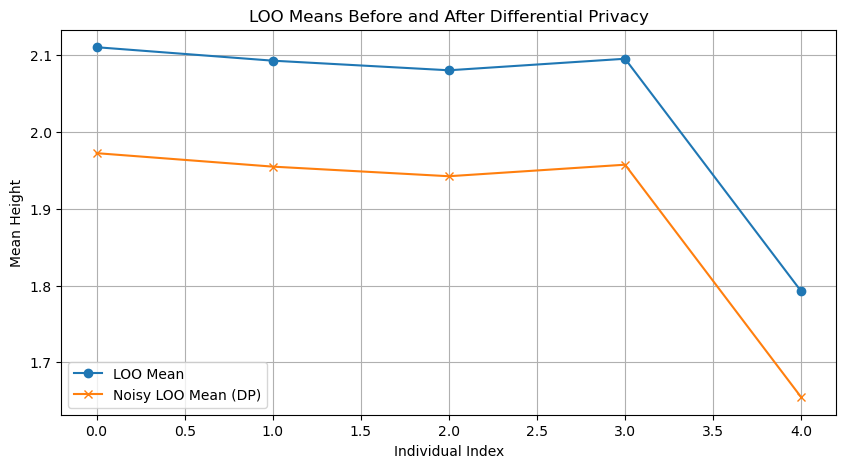

In [6]:
def dp(participants):
    all_noise = np.full(participants.shape[1], np.nan)

    for participant in range(participants.shape[1]):
        loo_estimate = participants[:, participant]
        true_mean = np.mean(loo_estimate)
        sensitivity = np.max(np.abs(true_mean - loo_estimate)) 
        noise = np.random.laplace(loc=0.0, scale=sensitivity)
        all_noise[participant] = noise
    
    return all_noise

aprx_est = aprx_est.T  # shape: (1, 5)
#tsv = TSVHandler().load("group-merged-1.tsv")
#height = tsv[:,0]

noise = dp(aprx_est)
noisy_mean = aprx_est.flatten() + 1 * noise.flatten()
plt.figure(figsize=(10, 5))
plt.plot(aprx_est.flatten(), label='LOO Mean', marker='o')
plt.plot(noisy_mean, label='Noisy LOO Mean (DP)', marker='x')
plt.title("LOO Means Before and After Differential Privacy")
plt.xlabel("Individual Index")
plt.ylabel("Mean Height")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
noise = dp(aprx_est)
print(f"Noise: {noise}")
noisy_mean = aprx_est + 1 * noise 
print(f"LOO mean: {aprx_est.flatten()}")
print(f"Noisy mean: {noisy_mean.flatten()}")
print(f"Found subject index:", np.argmin(np.abs(noisy_mean.flatten())))

Noise: [0.37959888]
LOO mean: [2.11   2.0925 2.08   2.095  1.7925]
Noisy mean: [2.48959888 2.47209888 2.45959888 2.47459888 2.17209888]
Found subject index: 4


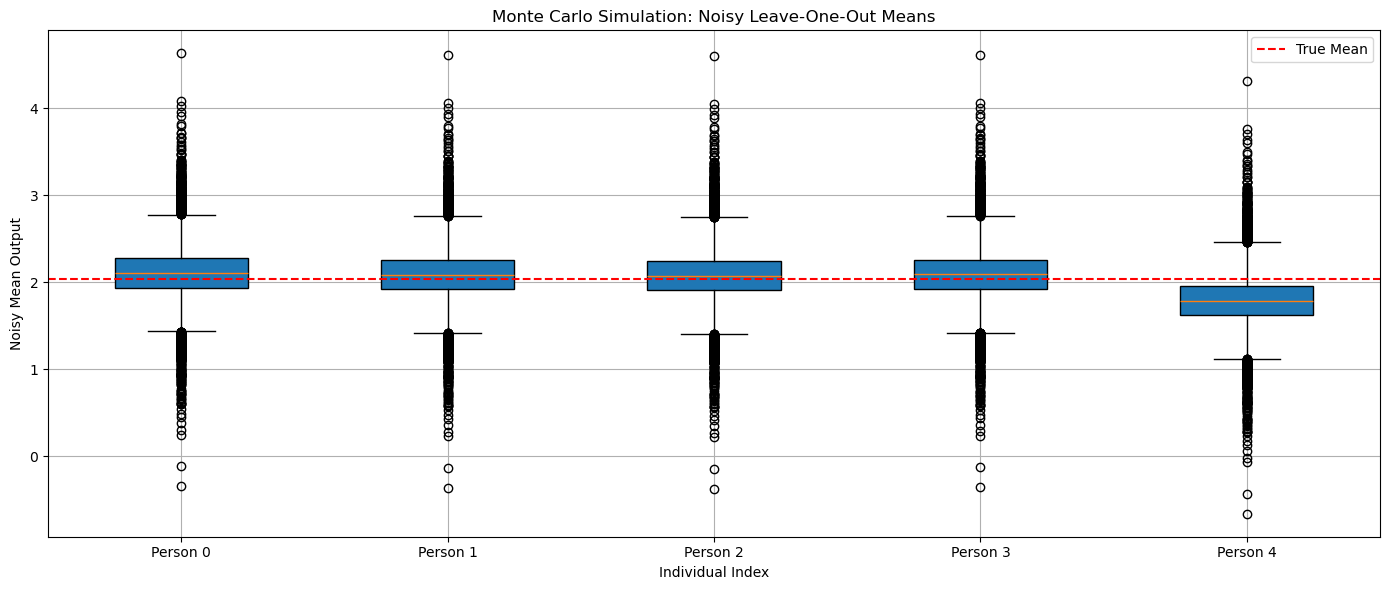

In [8]:
MC = 10000
noisy_outputs = np.full((MC,n), np.nan)

for i in range(MC):
    noise = dp(aprx_est)
    noisy_outputs[i] = aprx_est.flatten() + 1 * noise.flatten()
    
plt.figure(figsize=(14, 6))

plt.boxplot(noisy_outputs, labels=[f'Person {i}' for i in range(n)], patch_artist=True)
plt.axhline(y=true_mean, color='red', linestyle='--', label='True Mean')
plt.title("Monte Carlo Simulation: Noisy Leave-One-Out Means")
plt.xlabel("Individual Index")
plt.ylabel("Noisy Mean Output")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Interpretation

- Each box in the boxplot represents the distribution of the noisy mean computed when one individual is removed. Run over 10000 iterations.
- The red dashed line is the true mean of the original dataset.
- Despite adding noise, the values are centered around the true LOO means, showing the mechanism is statistically stable. The outputs do not reveal the exact values of individuals (especially the outlier), which validates the global privacy guarantee over repeated runs.